# Disable GPU (if needed)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def linear(x):
    return x

## Define build function

In [3]:
from tensorflow.contrib import slim
import tensorflow as tf
import keras.backend as K
from keras.layers import Input, Lambda
import numpy as np

def vgg16_build_func(input_shape=None):
    
    print(input_shape)
    if len(input_shape) == 3:
        input_shape = [1, *input_shape]

    # input_image
    input_image = tf.placeholder(
        tf.float32, shape=input_shape, name='input_image'
    )

    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                          activation_fn=linear,
                          weights_initializer=tf.constant_initializer(0.001),
                          biases_initializer=tf.constant_initializer(0.0),
                          weights_regularizer=slim.l2_regularizer(0.0005)):

        net = slim.repeat(input_image, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        net = slim.avg_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        net = slim.avg_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        net = slim.avg_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        net = tf.identity(net, name='feature_map0')
        net = slim.avg_pool2d(net, [2, 2], scope='pool4')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
        net = tf.identity(net, name='feature_map1')
        net = slim.max_pool2d(net, [2, 2], scope='pool5')
        net = slim.flatten(net, scope='flatten')
        net = slim.fully_connected(net, 4096, scope='fc6')
        net = slim.dropout(net, 0.5, scope='dropout6')
        net = slim.fully_connected(net, 4096, scope='fc7')
        net = slim.dropout(net, 0.5, scope='dropout7')
        net = slim.fully_connected(net, 1000, activation_fn=None, scope='fc8')

    return net


input_shape = (128, 128, 3)
graph = vgg16_build_func(input_shape=input_shape)
graph

/home/krzysiek/anaconda3/envs/receptivefield/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(128, 128, 3)


<tf.Tensor 'fc8/BiasAdd:0' shape=(1, 1000) dtype=float32>

# Tensorflow API

## Load example image

In [4]:
from receptivefield.image import get_default_image

image = get_default_image(shape=(96, 96), tile_factor=1)
image.shape

(288, 288, 3)

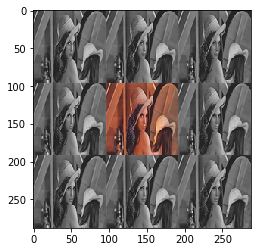

In [5]:
plt.imshow(image)
plt.savefig("../img/demo_tf_lena.jpg", dpi=126)

## Compute RF params for that network

In [6]:
from receptivefield.tensorflow import TFReceptiveField

rf = TFReceptiveField(vgg16_build_func)

In [7]:
rf_params = rf.compute(
    input_shape=image.shape,
    input_layer='input_image', 
    output_layers=['feature_map0', 'feature_map1']
)

ImageShape(w=288, h=288, c=3)


[2018-07-20 08:48:26,364][ INFO][tensorflow.py]::Feature maps shape: [(1, 36, 36, 1), (1, 18, 18, 1)]
[2018-07-20 08:48:26,365][ INFO][tensorflow.py]::Input shape       : [1, 288, 288, 3]
[2018-07-20 08:48:29,204][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=92, h=92))
[2018-07-20 08:48:29,204][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(8.0, 8.0), stride=(16.0, 16.0), size=Size(w=196, h=196))


In [8]:
rf.input_shape

ImageShape(w=288, h=288, c=3)

In [9]:
rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=36, h=36), rf=ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=92, h=92))),
 FeatureMapDescription(size=Size(w=18, h=18), rf=ReceptiveFieldDescription(offset=(8.0, 8.0), stride=(16.0, 16.0), size=Size(w=196, h=196)))]

## Plot example receptive field response

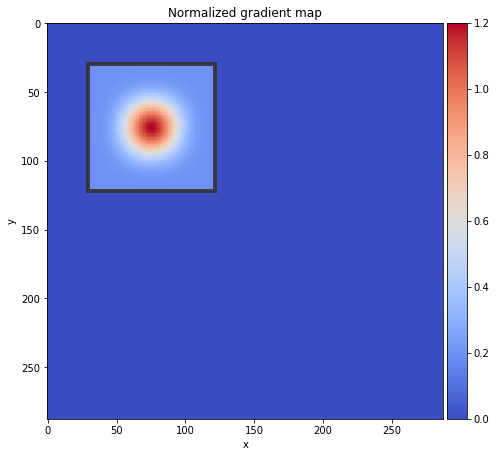

In [10]:
rf.plot_gradient_at(0, (9, 9), image=None, figsize=(7, 7))
plt.savefig("../img/demo_tf_response.jpg", dpi=128)

## Debug receptive field

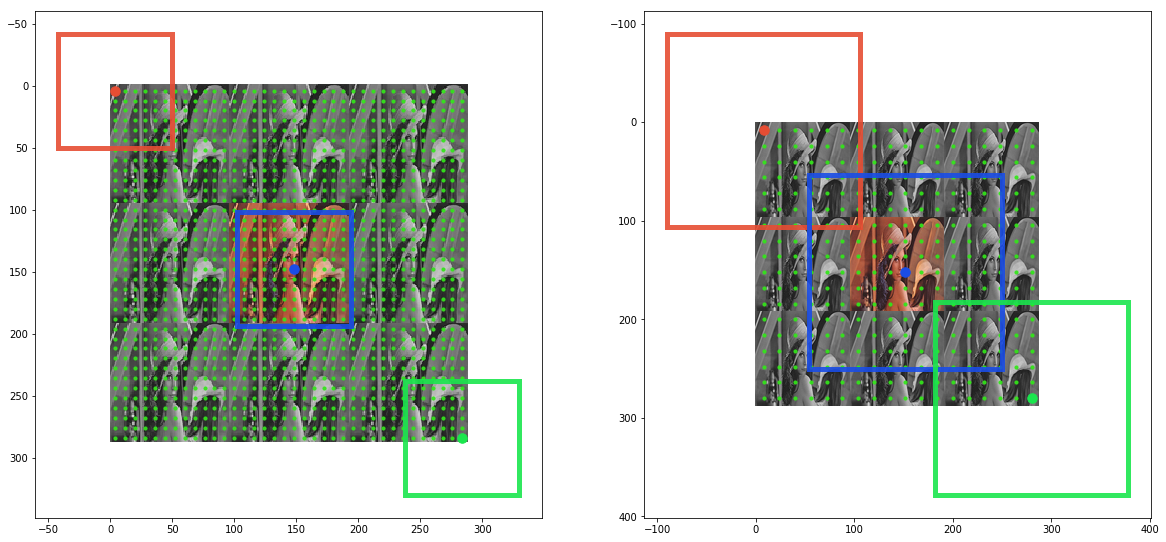

In [11]:
rf.plot_rf_grids(custom_image=image, figsize=(20, 12), layout=(1, 2))
plt.savefig("../img/demo_tf_rf_debug.jpg", dpi=128)

## Same but using subplot

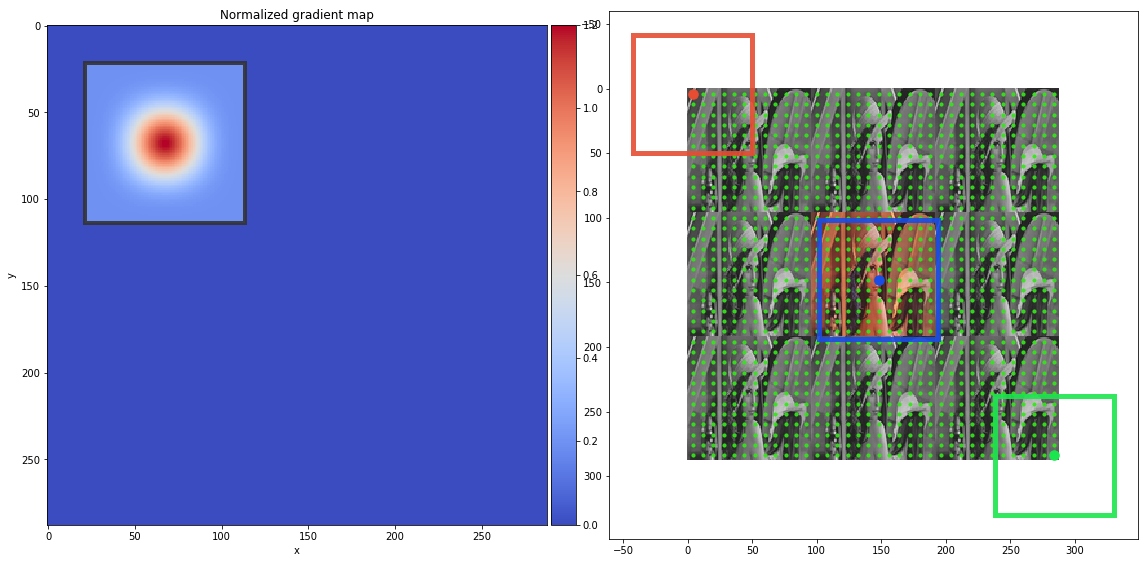

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
rf.plot_gradient_at(0, (8, 8), image=None, axis=ax)
ax = plt.subplot(122)
rf.plot_rf_grid(0, custom_image=image, axis=ax)

## Secondary API

For this API names are not important, but build function must accepts input image tensor and returns a list of feature maps tensors for which one wants to compute receptive field

In [19]:
def vgg16_fm_build_func(input_image):
    """
    A function which accepts image tensor [1, width, height, num_channels] and 
    returns a list of feature maps of shape [1, fm_width, fm_height, fm_channels]
    """
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                          activation_fn=linear,
                          weights_initializer=tf.constant_initializer(0.001),
                          biases_initializer=tf.constant_initializer(0.0),
                          weights_regularizer=slim.l2_regularizer(0.0005)):
        
        net = slim.repeat(input_image, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        net = slim.avg_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        net = slim.avg_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        net = slim.avg_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        fm0 = net # first feature map
        net = slim.avg_pool2d(net, [2, 2], scope='pool4')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
        fm1 = net # second feature map
        
    return [fm0, fm1]

In [20]:
from receptivefield.tensorflow import TFFeatureMapsReceptiveField

rf = TFFeatureMapsReceptiveField(vgg16_fm_build_func)
rf.compute(input_shape=image.shape)

[2018-07-20 08:57:46,898][ INFO][tensorflow.py]::Feature maps shape: [(1, 36, 36, 1), (1, 18, 18, 1)]
[2018-07-20 08:57:46,899][ INFO][tensorflow.py]::Input shape       : [1, 288, 288, 3]
[2018-07-20 08:57:48,514][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=92, h=92))
[2018-07-20 08:57:48,515][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(8.0, 8.0), stride=(16.0, 16.0), size=Size(w=196, h=196))


In [21]:
rf.feature_maps_desc

[FeatureMapDescription(size=Size(w=36, h=36), rf=ReceptiveFieldDescription(offset=(4.0, 4.0), stride=(8.0, 8.0), size=Size(w=92, h=92))),
 FeatureMapDescription(size=Size(w=18, h=18), rf=ReceptiveFieldDescription(offset=(8.0, 8.0), stride=(16.0, 16.0), size=Size(w=196, h=196)))]

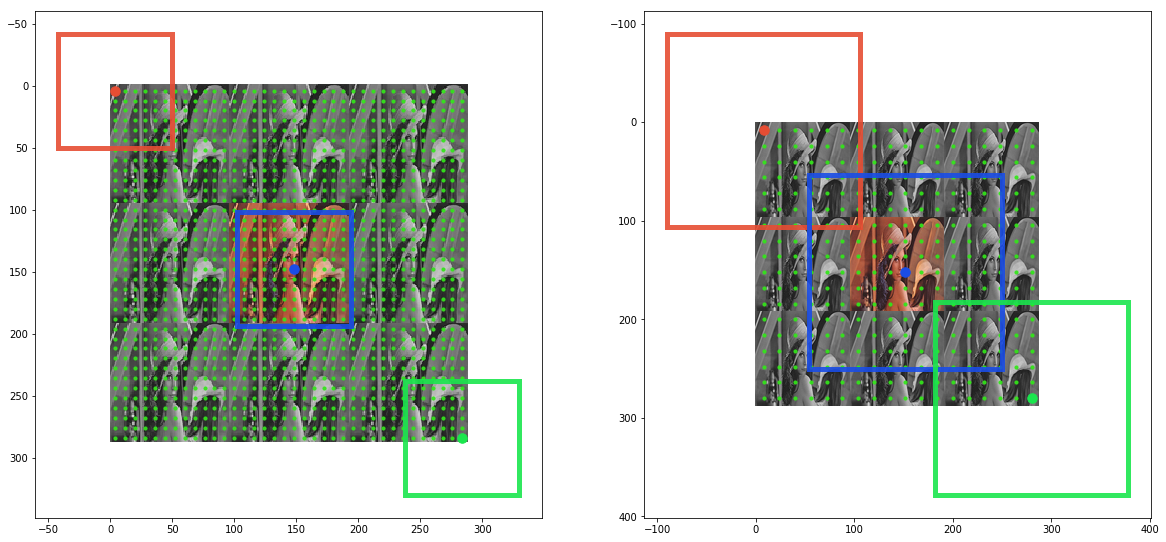

In [22]:
rf.plot_rf_grids(custom_image=image, figsize=(20, 12), layout=(1, 2))